In [109]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

### In this version if a healthy individual(blue) is connected to an infected(red) there is a probability I that they
### will become infected. If an individual is red there is a probability R of becoming blue. We assume no immunity 
### after recovery, and also DONT assume that if an infected individual has only infected neighours they are 
### immune to recovery

In [110]:
n = 1000
k = 5 # on average the number of friends one has
p = 0.2 # probability of rewiring in the Wats-Strogatz algorithm

G = nx.connected_watts_strogatz_graph(n,k,p) # Small-world network

In [111]:
for j in range(n):
    G.nodes[j]['color'] = 'blue' # not infected

In [112]:
init_inf = 0.03 # proportion of infected people
threshold_up = 0.2*n # when the disease is successful
threshold_down = 0.01*n # when it dies off

init_distr = np.random.choice(n, int(round(n*init_inf)), replace=False) #Initial infected nodes

inf = int(round(n*init_inf))

In [113]:
for j in init_distr:
    G.nodes[j]['color'] = 'red' # infect

In [114]:
# Using standard SIR model

R = 0.01 #recovery probability
I = 0.1 #infection probability

nextstate = np.zeros(n)
inf_t =np.array([100*inf/n]) # infected at time t

In [115]:
while (threshold_down<inf<threshold_up):
    for n, nbrs in G.adj.items():            #These two lines are a weird artefact for accesing neighbours in nx
            if G.nodes[n]['color'] == 'blue':
                if any([G.nodes[nbr]['color']=='red'] for nbr, eatr in nbrs.items() ):
                    nextstate[n]=np.random.binomial(1,I)
                else:
                    nextstate[n]=0
            else:                            #else it is infected and has probability of flipping and becoming succeptible again
                nextstate[n]=np.random.binomial(1,(1-R))
    inf = sum(nextstate)
    inf_t = np.append(inf_t,[100*inf/n])
    for j in range(n):
        if nextstate[j] == 0:
            G.nodes[j]['color'] = 'blue'
        else:
            G.nodes[j]['color'] = 'red'

The disease won and the infection level is 20.62%


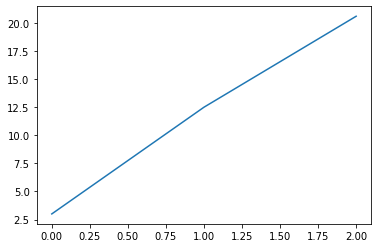

In [116]:
if inf<threshold_down:
    print("The disease was wiped out and the infection level is {}".format(round(100*inf/n,2)) )
if inf>threshold_up:
    print("The disease won and the infection level is {}%".format(round(100*inf/n,2)) )

plt.plot(inf_t)
plt.show()

This is expected since the recovery rate is much lower than the infection rate, there is essentially no way for the dissease to slow down.

We shall continue looking at the ones where we introduce immunity.

In [117]:
F = nx.connected_watts_strogatz_graph(n,k,p) 

for j in range(n):
    F.nodes[j]['color'] = 'blue' 
    
for j in init_distr:
    F.nodes[j]['color'] = 'red'
    
inf = int(round(n*init_inf))
inf_t_immune = np.array([100*inf/n])

In [118]:
while (threshold_down<inf<threshold_up):
    for n, nbrs in F.adj.items():            #These two lines are a weird artefact for accesing neighbours in nx
            if F.nodes[n]['color'] == 'blue':
                if any([F.nodes[nbr]['color']=='red'] for nbr, eatr in nbrs.items() ):
                    nextstate[n]=np.random.binomial(1,I)
                else:
                    nextstate[n]=0
            else:                            #else it is infected and has probability of flipping and becoming succeptible again
                nextstate[n]=int(np.random.binomial(1,R) + 1) #2 means immune now
    inf = list(nextstate).count(1)
    inf_t_immune = np.append([inf_t_immune],[100*inf/n])
    for j in range(n):
        if nextstate[j] == 0:
            F.nodes[j]['color'] = 'blue'
        elif nextstate[j] == 1:
            F.nodes[j]['color'] = 'red'
        else:
            F.nodes[j]['color'] = 'green' #immune
    

The disease won and the infection level is 22.34%


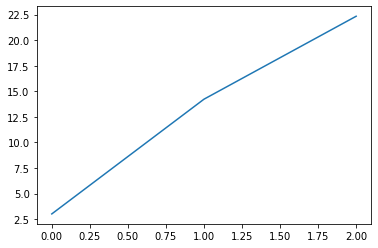

In [119]:
if inf<threshold_down:
    print("The disease was wiped out and the infection level is {}".format(round(100*inf/n,2)) )
if inf>threshold_up:
    print("The disease won and the infection level is {}%".format(round(100*inf/n,2)) )
    
plt.plot(inf_t_immune)
plt.show()